#                                       **CIFAR-10: Image Classification**

#   Step 1: Data Preprocessing & Loading 
##  Visualization of Images and Labels / Inserting Grayscale Conversion / Augmentation 


In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dropout, RandomFlip, RandomRotation, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.utils import to_categorical


In [54]:
# Load the CIFAR-10 Dataset
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

In [55]:
# Check data dimensions
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


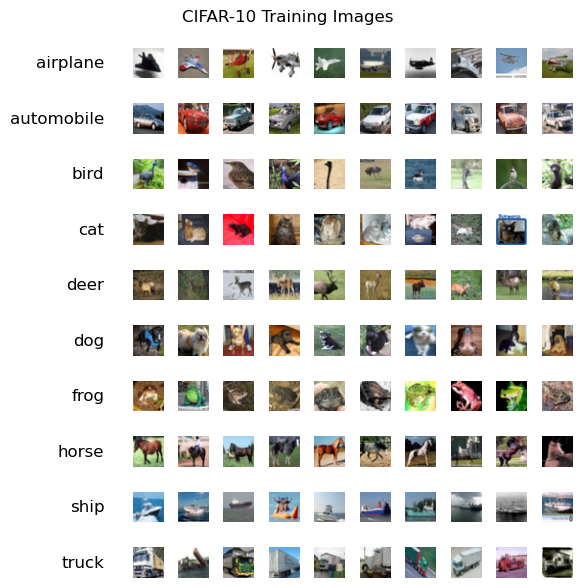

None


In [56]:
# Define a list with all the class labels for CIFAR-10
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Function to visualize color images from CIFAR-10 dataset with correct labeling
def visualize_images_with_labels(images, labels, classes, images_per_class=10, title="CIFAR-10 Images"):
    num_classes = len(classes)
    total_images = num_classes * images_per_class

    plt.figure(figsize=(6, 6))
    image_count = 0

    # Loop through class labels to pick images_per_class images per class
    for class_index, class_name in enumerate(classes):
        class_images = images[labels.flatten() == class_index][:images_per_class]

        # Loop through the images, arranging them dynamically
        for img in class_images:
            plt.subplot(num_classes, images_per_class, image_count + 1)
            plt.imshow(img)
            plt.axis('off')
            
            # Add class label to the left side of each row
            if image_count % images_per_class == 0:
                plt.text(-30, 32 // 2, class_name, rotation=0, size='large', va='center', ha='right')
            
            image_count += 1
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Visualize color images from the CIFAR-10 training set
visualize_color_images = visualize_images_with_labels(x_train, y_train, classes, images_per_class=10, title="CIFAR-10 Training Images")
print(visualize_color_images)


In [57]:
# Data Augmentation:

# Convert images to grayscale

grayscale_x_train = tf.image.rgb_to_grayscale(x_train)
grayscale_x_test = tf.image.rgb_to_grayscale(x_test)

gray_x_train = np.array(grayscale_x_train)
gray_x_test = np.array(grayscale_x_test)

print(gray_x_train.shape)
print(gray_x_test.shape)

# Create augmentation layer for model (used further down)

data_augmentation = Sequential([
layers.RandomFlip("horizontal_and_vertical"),
layers.RandomRotation(0.2),
]) 


(50000, 32, 32, 1)
(10000, 32, 32, 1)


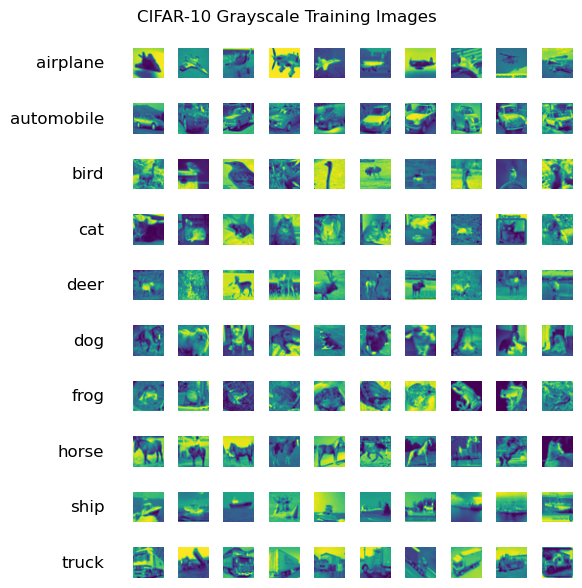

None


In [58]:
# Visualize grayscale images from the CIFAR-10 training set
visualize_gray_images = visualize_images_with_labels(gray_x_train, y_train, classes, images_per_class=10, title="CIFAR-10 Grayscale Training Images")
print(visualize_gray_images)

#   Step 2: Train/ Test and Validation Split


In [59]:
# Normalize the images to the range [0, 1]
x_train_normalized = gray_x_train.astype('float32') / 255.0
x_test_normalized = gray_x_test.astype('float32') / 255.0

print(x_train_normalized.shape)
print(x_test_normalized.shape)

(50000, 32, 32, 1)
(10000, 32, 32, 1)


In [60]:
# One-hot encode the labels
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

print(y_train_cat.shape)
print(y_test_cat.shape)

(50000, 10)
(10000, 10)


# Step 3: Defining and training model

In [61]:
# Perform the train-validation split with stratefied sampling
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, val_idx in strat_split.split(x_train_normalized, y_train):
    x_train_normalized_split = x_train_normalized[train_idx]
    x_val_split = x_train_normalized[val_idx]
    y_train_split = y_train_cat[train_idx]
    y_val_split = y_train_cat[val_idx]

# Verify the distribution
def class_distribution(y_data):
    classes, counts = np.unique(np.argmax(y_data, axis=1), return_counts=True)
    return dict(zip(classes, counts))

print("Training set class distribution:", class_distribution(y_train_split))
print("Validation set class distribution:", class_distribution(y_val_split))

Training set class distribution: {0: 4000, 1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000, 6: 4000, 7: 4000, 8: 4000, 9: 4000}
Validation set class distribution: {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


In [62]:
# Define model / data parameters
num_classes = 10
input_shape = x_train_normalized.shape[1:]
dropout_rate = 0.2
epochs = 30
batch_size = 64

# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define custom optimizer, learning rate
optimizer = Adam(learning_rate = 0.001)

# Define the model with data augmentation
model = Sequential([
    layers.Input(shape=input_shape),
    data_augmentation,  # Data augmentation layer

    layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    layers.AveragePooling2D(pool_size=(2, 2), padding="same"),

    layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), padding="same"),

    layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    layers.AveragePooling2D(pool_size=(2, 2), padding="same"),

    layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), padding="same"),

    layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    BatchNormalization(),

    layers.Flatten(),

    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    #layers.Dropout(dropout_rate),

    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    #layers.Dropout(dropout_rate),

    layers.Dense(num_classes, activation='softmax')
])

# Print summary of the model
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_17 (Sequential)  (None, 32, 32, 1)         0         
                                                                 
 conv2d_208 (Conv2D)         (None, 32, 32, 64)        640       
                                                                 
 conv2d_209 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_68 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_210 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 conv2d_211 (Conv2D)         (None, 32, 32, 64)        36928     
                                                     

In [63]:
# Compile the model
model.compile(optimizer = optimizer,
              loss ='categorical_crossentropy',
              metrics = ['accuracy'])

# Train the model with normalized data
history = model.fit(x_train_normalized_split, y_train_split, validation_data=(x_val_split, y_val_split), epochs = epochs, batch_size = batch_size, callbacks = [early_stopping])

Epoch 1/30
625/625 [==============================] - 138s 216ms/step - loss: 2.0517 - accuracy: 0.2354 - val_loss: 2.1569 - val_accuracy: 0.2477
Epoch 2/30
625/625 [==============================] - 136s 217ms/step - loss: 1.7842 - accuracy: 0.3271 - val_loss: 2.3143 - val_accuracy: 0.2364
Epoch 3/30
625/625 [==============================] - 133s 213ms/step - loss: 1.6340 - accuracy: 0.3876 - val_loss: 1.7308 - val_accuracy: 0.3820
Epoch 4/30
625/625 [==============================] - 134s 214ms/step - loss: 1.5287 - accuracy: 0.4393 - val_loss: 2.4152 - val_accuracy: 0.3411
Epoch 5/30
625/625 [==============================] - 134s 215ms/step - loss: 1.4261 - accuracy: 0.4876 - val_loss: 1.4653 - val_accuracy: 0.5069
Epoch 6/30
625/625 [==============================] - 134s 214ms/step - loss: 1.3397 - accuracy: 0.5246 - val_loss: 2.0238 - val_accuracy: 0.3899
Epoch 7/30
625/625 [==============================] - 132s 211ms/step - loss: 1.2743 - accuracy: 0.5490 - val_loss: 1.5121 -

#  Step 4: Model Evaluation
## Evaluate the Model and Compute Metrics

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
[2.051744222640991, 1.784197449684143, 1.6339787244796753, 1.528715968132019, 1.426108956336975, 1.339728832244873, 1.2742815017700195, 1.2245640754699707, 1.1867408752441406, 1.1454243659973145, 1.1135443449020386, 1.0687521696090698, 1.0445245504379272, 1.0053527355194092, 0.9743956923484802, 0.9591573476791382, 0.9220616221427917, 0.9125335812568665, 0.8828042149543762, 0.8652452230453491, 0.849128782749176, 0.8298457860946655, 0.8167338371276855, 0.794063150882721, 0.7847830653190613, 0.774431049823761, 0.7644729614257812, 0.7453856468200684, 0.7418723106384277, 0.7283512949943542]
[0.23542499542236328, 0.32714998722076416, 0.38760000467300415, 0.439300000667572, 0.48762500286102295, 0.5245749950408936, 0.5490249991416931, 0.5681750178337097, 0.5834500193595886, 0.5988749861717224, 0.6129999756813049, 0.6284999847412109, 0.6373500227928162, 0.6503999829292297, 0.6599000096321106, 0.6690750122070312, 0.681850016117096, 0.68

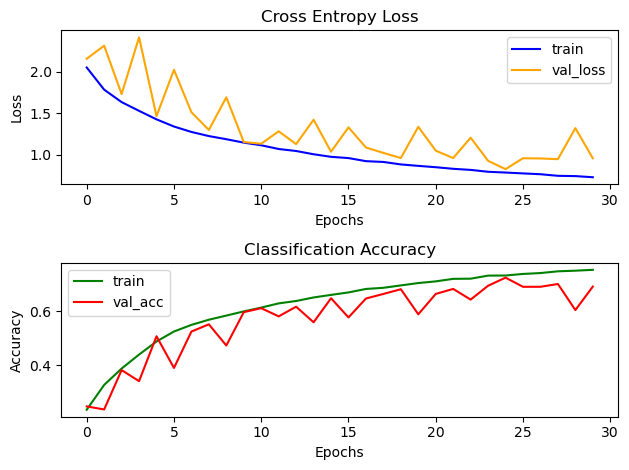

In [64]:
# Print training accuracy and loss curves
print(history.history.keys())

print(history.history['loss']) # returns the loss value at the end of each epoch
print(history.history['accuracy']) # returns the accuracy at the end of each epoch

# Plot loss
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='green', label='train')
plt.plot(history.history['val_accuracy'], color='red', label='val_acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [65]:
# Make prediction
predictions = model.predict(x_test_normalized)

y_pred = np.argmax(predictions, axis=1)


313/313 [==============================] - 9s 27ms/step


In [69]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")

# Compute precision score, recall and F1
precision = precision_score(y_test, y_pred, average = "macro")
recall = recall_score(y_test, y_pred, average = "macro")
f1 = f1_score(y_test, y_pred, average = "macro")

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Test Accuracy: 0.6861
Precision: 0.7029918994212966
Recall: 0.6860999999999999
F1 Score: 0.6851801237891207


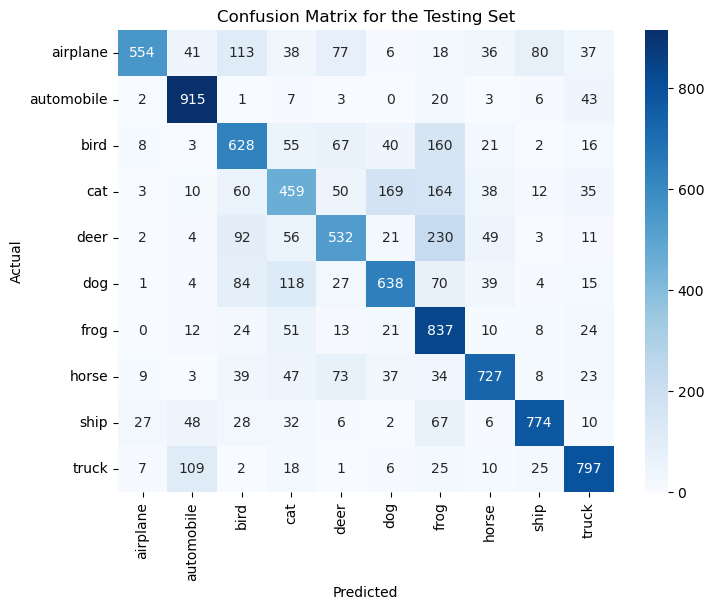

In [70]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels = classes, yticklabels = classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for the Testing Set')
plt.show()